In [231]:
%reset -f

In [232]:
import os
import sys
import scipy as sp
import numpy as np
import astropy as ap
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import astropy.cosmology as apc
from astropy.cosmology import Planck18
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import fitsio
import kcorrect
sys.path.append('/home/ygence/kmeans_radec')
import kmeans_radec as kr

c = 3e18    #A * Hz
cosmo = FlatLambdaCDM(H0=70, Om0=0.3065)

In [233]:
path = '/shares/soares-santos.physik.uzh/catalogs'
f = os.path.join(path, 'des_y3_gold_flags.fits')

In [234]:
# gets column names
fitsio.read_header(f, ext=1)


XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / array data type
NAXIS   =                    2 / number of array dimensions
NAXIS1  =                  154 / length of dimension 1
NAXIS2  =            399264629 / length of dimension 2
PCOUNT  =                    0 / number of group parameters
GCOUNT  =                    1 / number of groups
TFIELDS =                   23 / number of table fields
TTYPE1  = 'sof_cm_mag_corrected_g' / 
TFORM1  = 'D'                  / 
TTYPE2  = 'sof_cm_mag_corrected_r' / 
TFORM2  = 'D'                  / 
TTYPE3  = 'sof_cm_mag_corrected_i' / 
TFORM3  = 'D'                  / 
TTYPE4  = 'sof_cm_mag_corrected_z' / 
TFORM4  = 'D'                  / 
TTYPE5  = 'flags_gold'         / 
TFORM5  = 'J'                  / 
TTYPE6  = 'flags_foreground'   / 
TFORM6  = 'J'                  / 
TTYPE7  = 'flags_footprint'    / 
TFORM7  = 'J'                  / 
TTYPE8  = 'flags_badregions'   / 
TFORM8  = 'J'                  /

In [235]:
# loading data (1e6 to start)
rows = range(0,1000000)
fits = fitsio.read(f, rows=rows, ext=1)

In [236]:
magmaskgu = fits['sof_cm_mag_corrected_g'] <= 24.5
magmaskru = fits["sof_cm_mag_corrected_r"] <= 24.5
magmaskiu = fits["sof_cm_mag_corrected_i"] <= 24.5
magmaskzu = fits["sof_cm_mag_corrected_z"] <= 24.5

magmaskgl = fits['sof_cm_mag_corrected_g'] >= 10
magmaskrl = fits["sof_cm_mag_corrected_r"] >= 10
magmaskil = fits["sof_cm_mag_corrected_i"] >= 10
magmaskzl = fits["sof_cm_mag_corrected_z"] >= 10

mask1 = fits['extended_class_mash_sof'] == 3
mask2 = fits['flags_footprint'] == 1
mask3 = fits['flags_foreground'] == 0
mask4 = fits['flags_badregions'] < 4
mask5 = fits['flags_gold'] == 0

zmaskh = fits['dnf_zmean_sof'] > 0
zmaskl = fits['dnf_zmean_sof'] < 2

mask_total = zmaskh & zmaskl & mask1 & mask2 & mask3 & mask4 & mask5 & magmaskgu & magmaskru & magmaskiu & magmaskzu & magmaskgl & magmaskrl & magmaskil & magmaskzl

In [237]:
# data loading for objects
fits = fits[mask_total]
mrows = np.shape(fits)

In [238]:
fits['hpix_16384']

array([2358438295, 2408312636, 2337924977, ..., 2334620463, 3066309524,
       1230985777], shape=(439534,), dtype='>i8')

In [239]:
x = len(fits)

ra = fits['alphawin_j2000']
ra[ra > 180.] -= 360.
dec = fits['deltawin_j2000']

mag_list = []
mag_err_list = []

for i in range(x):
    m = np.array([fits[i]['sof_cm_mag_corrected_g'],fits[i]['sof_cm_mag_corrected_r'],fits[i]['sof_cm_mag_corrected_i'],fits[i]['sof_cm_mag_corrected_z']])     # appmags with k inside
    mag_list.append(m)
    m_err = np.array([fits[i]['sof_cm_mag_err_g'],fits[i]['sof_cm_mag_err_r'],fits[i]['sof_cm_mag_err_i'],fits[i]['sof_cm_mag_err_z']]) # appmag errors
    mag_err_list.append(m_err)


phot_reds = fits['dnf_zmean_sof']         # photometric redshifts
phot_reds_err = fits['dnf_zsigma_sof']    # redshift errors

d_L = cosmo.luminosity_distance(phot_reds)/u.Mpc
d_Lerr = cosmo.luminosity_distance(phot_reds_err)/u.Mpc

DM = 25 + 5*np.log10(d_L)
DM_err = 5/(np.log(10)*d_L) * d_Lerr

DM = np.broadcast_to(DM.reshape(-1,1), (x,4))
DM_err = np.broadcast_to(DM_err.reshape(-1,1), (x,4))

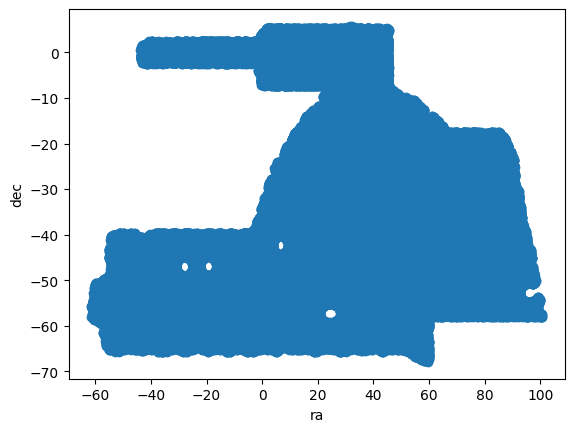

In [240]:
# visualizing the galaxies on the sky
plt.scatter(ra, dec)
plt.xlabel('ra')
plt.ylabel('dec')
plt.show()
plt.close()

# Data Processing

In [241]:
f_nu_list = []
err_fnu_list = []
ivar_list = []

for i in range(x):
    f_nu = 10**(-0.4*mag_list[i])        # 'dirty' appmags -> 'dirty' maggies
    f_nu_list.append(f_nu)

    # from std error propagation
    err_fnu = mag_err_list[i] * 0.4 * np.log(10) * 10**(-0.4*mag_list[i]) # from f_err**2 = |df/dm|**2 m_err**2, this is the standard deviation of the flux
    err_fnu_list.append(err_fnu)
    
    ivars = err_fnu**(-2)
    ivar_list.append(ivars)

# K correction

In [242]:
# getting k correction values
responses = ['decam_g','decam_r','decam_i','decam_z']
kz = kcorrect.kcorrect.Kcorrect(responses=responses, cosmo=cosmo)

maggies = f_nu_list
ivar = ivar_list    # inverse variance = (1/std.dev.)^2
redshift = phot_reds

coeffs = kz.fit_coeffs(redshift=redshift, maggies=maggies, ivar=ivar)

K = kz.kcorrect(redshift=redshift, coeffs=coeffs)       # we have k values to clean out redshift effects from the appmag

derived = kz.derived(redshift=redshift, coeffs=coeffs)
sm = derived['mremain']

In [243]:
f_nu_list = []
err_fnu_list = []
ivar_list = []

In [244]:
M = []
for i in range(x):
    M_calc = mag_list[i] -DM[i] -K[i]
    M.append(M_calc)
M = np.array(M)

In [245]:
err_M = []
for i in range(x):
    M_calc_err = np.sqrt(mag_err_list[i]**2 + DM_err[i]**2)
    err_M.append(M_calc_err)
err_M = np.array(err_M)

In [246]:
mag_list = []
mag_err_list = []

Visualisation

In [247]:
M_g = np.array([row[0] for row in M])
M_r = np.array([row[1] for row in M])
M_i = np.array([row[2] for row in M])
M_z = np.array([row[3] for row in M])

In [248]:
err_M_g = np.array([row[0] for row in err_M])
err_M_r = np.array([row[1] for row in err_M])
err_M_i = np.array([row[2] for row in err_M])
err_M_z = np.array([row[3] for row in err_M])

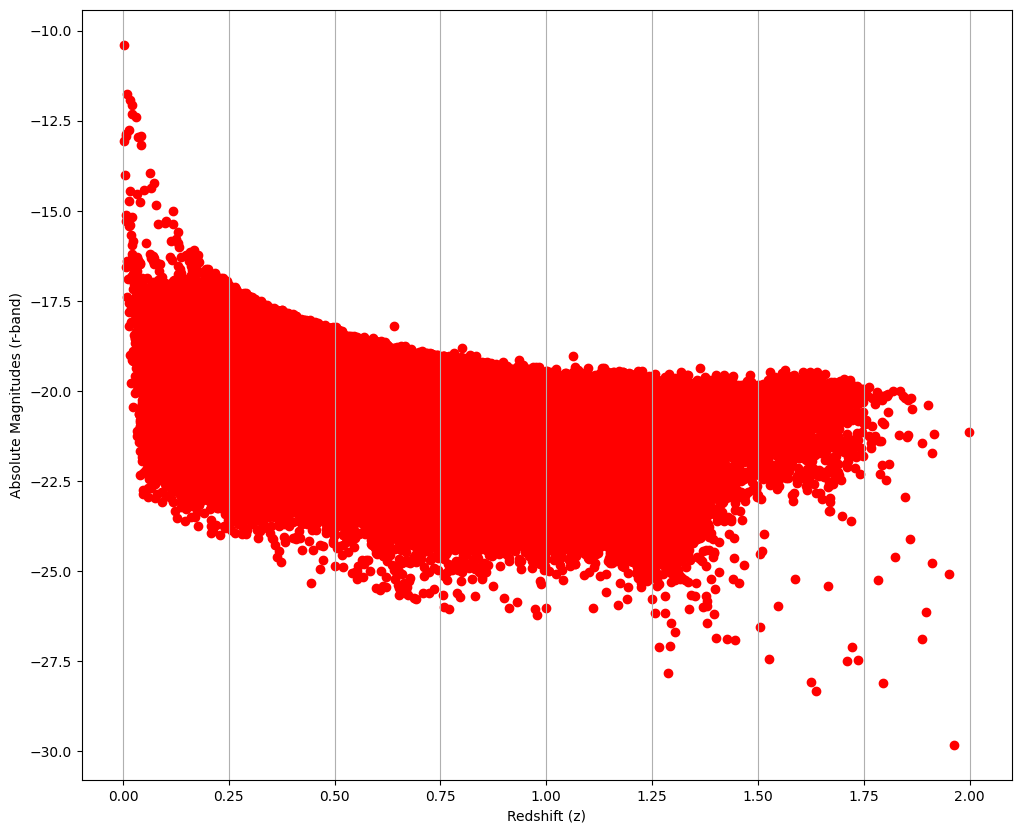

In [249]:
fig, ax = plt.subplots()
plt.scatter(phot_reds, M_r, marker="o", c='r')

ax.set_yscale('linear')
ax.set_xscale('linear')

ax.set_xlabel('Redshift (z)')
ax.set_ylabel('Absolute Magnitudes (r-band)')

ax.grid(axis='x')

fig.set_size_inches(12,10)
plt.show()
plt.close()

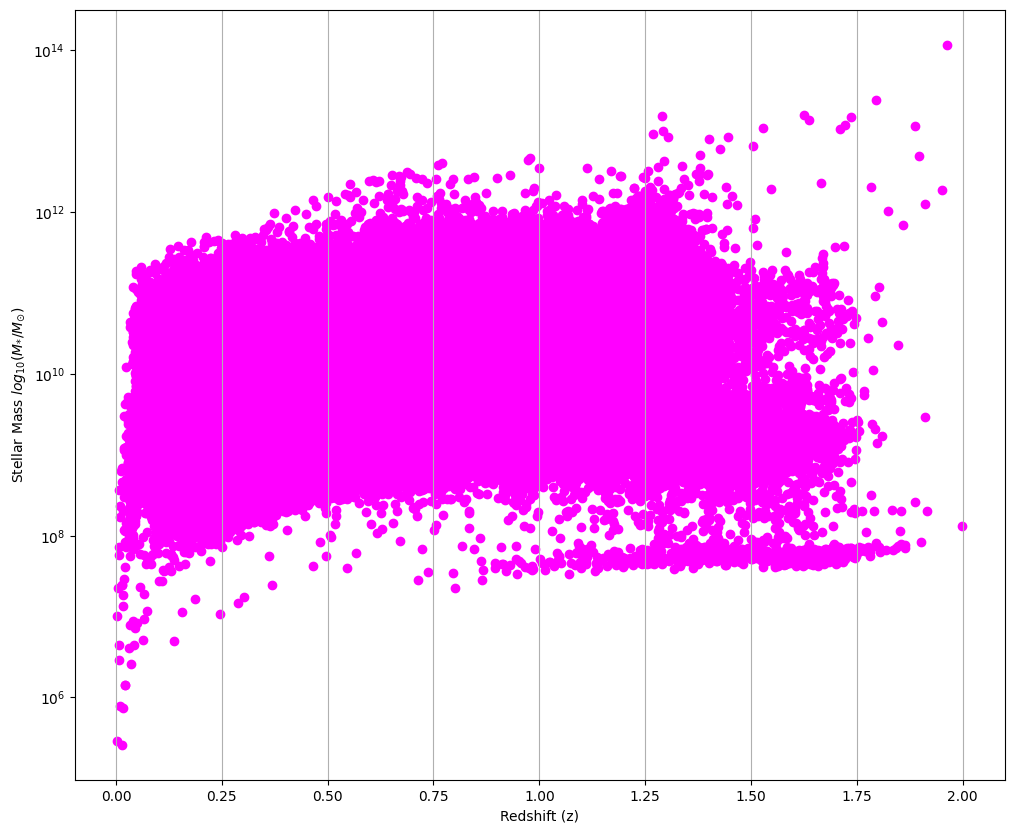

In [250]:
fig, ax = plt.subplots()
plt.scatter(phot_reds, sm, marker='o', c='fuchsia')

ax.set_yscale('log')
ax.set_xscale('linear')

ax.set_ylabel(r'Stellar Mass $log_{10}(M_{*}/M_{\odot})$')
ax.set_xlabel('Redshift (z)')
ax.grid(axis='x')

fig.set_size_inches(12,10)
plt.show()
plt.close()

Data Saving

In [ ]:
neofits = fitsio.FITS('/home/ygence/scratch/DES_Y3_1M.fits','rw')
arr_list = [phot_reds, phot_reds_err, M_g, err_M_g, M_r, err_M_r, M_i, err_M_i, M_z, err_M_z, sm, ra, dec]
names = ['z','z_err','M_g','M_err_g','M_r','M_err_r','M_i','M_err_i','M_z','M_err_z','SM','ra','dec']
neofits.write(arr_list, names=names)
#neofits[-1].append(arr_list,names=names)
neofits.close()

# Schechter Form of the Luminosity Function

In [ ]:
%reset -f

In [ ]:
import os
import sys
import scipy as sp
import numpy as np
import astropy as ap
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import astropy.cosmology as apc
from astropy.cosmology import Planck18
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import fitsio
import kcorrect
sys.path.append('/home/ygence/kmeans_radec')
import kmeans_radec as kr

sch_c = 3e5 * u.km/u.s
cosmo = FlatLambdaCDM(H0=70, Om0=0.3065)

In [ ]:
fitsio.read_header('/home/ygence/scratch/DES_Y3_1M_random.fits',ext=1)

In [ ]:
fits = fitsio.read('/home/ygence/scratch/DES_Y3_1M_random.fits', ext=1)

In [ ]:
maskMl = fits['M_r'] > (-24)
maskMh = fits['M_r'] < (-16)
maskz = fits['z'] < 0.5
maskM = maskMl & maskMh & maskz
fits = fits[maskM]

In [ ]:
ra = fits['ra']
dec = fits['dec']

schM = fits['M_r']
schM_err = fits['M_err_r']
schM_l = schM.min()
schM_u = schM.max()

sch_z = fits['z']
sch_z_err = fits['z_err']
sch_z_max = sch_z.max()

sch_dl = cosmo.luminosity_distance(sch_z)

In [ ]:
X = np.array([ra,dec]).T

cellno = 100

In [ ]:
# run no more than 100 iterations. Will stop if tolerance is met
km = kr.kmeans_sample(X, cellno, maxiter=100, tol=1.0e-5)

# we got back a KMeans object:

# the centers found by the algorithm
print("found centers:",km.centers)

# did we converge?
print("converged?",km.converged)

# labels are the index to the nearest center for each point in X
print("labels size:",km.labels.size)

# how many in each cluster? Should be fairly uniform
print("cluster sizes:", np.bincount(km.labels))

# the distance to each center [Npoints, Ncen]
print("shape of distances:",km.distances.shape)

centers = km.centers

In [ ]:
cell_list = [[] for _ in range(cellno)]
num = np.arange(0,cellno)
eventno = len(sch_z)

for i in np.arange(0,eventno):
    cell_list[km.labels[i]].append(i)


Defining the the comoving volume function (Eales 1993)

In [ ]:
def V(x):
    return ((1+x)**2 * np.sqrt(cosmo.Ode0 + cosmo.Om0 * (1+x)**3))**(-1)

survey_area = 4946
integ,_ = sp.integrate.quad(lambda x:V(x), 0,sch_z_max)
V_max = np.array(survey_area*sch_c*sch_dl**2/cosmo.H0 * integ /u.Mpc**3)   # defining Vmax

In [ ]:
counts,edges = np.histogram(schM, bins=int(np.sqrt(len(schM)))) # binning the absolute mags
optedges = 0.5*(edges[1:]+edges[:-1])
s=pd.Series(counts,index=optedges)
s.plot()

In [ ]:
sumIV_max_binned = np.zeros(len(counts))    # 1/Vmax summation based on the absmag bins

prevEnd = 0

for idx, count in enumerate(counts):
    V_max_for_count = V_max[prevEnd:prevEnd+count]
    sumIV_max_binned[idx] = np.sum(1/V_max_for_count)

    prevEnd = prevEnd + count

plt.plot(optedges, sumIV_max_binned)
plt.yscale('log')

Defining the Schechter function

In [ ]:
from scipy.optimize import curve_fit

#single
def func(x, M_star, alpha, phi):
    return 0.4*np.log(10)*phi*10**(-0.4*(1+alpha)*(x-M_star))*np.exp(-1*(10)**(-0.4*(x-M_star)))

#double
def doubfunc(x, M_star, alpha1, phi1, alpha2, phi2):
    return 0.4*np.log(10)*(phi1*10**(-0.4*(1+alpha1)*(x-M_star))+phi2*10**(-0.4*(1+alpha2)*(x-M_star)))*np.exp(-1*(10)**(-0.4*(x-M_star)))

In [ ]:
#fit_sel = (optedges > -24) & (optedges < -16)       # masking for bad data

coeffs, cov = curve_fit(func, optedges, sumIV_max_binned, p0=[-21,-1,1]) #fitting the Schechter function

stddev = np.sqrt(cov) #recovering the std. dev.

stddiag = [-stddev[0,0],-stddev[1,1],stddev[2,2]] # to keep the error bar lines consistent

coeffs, cov

In [ ]:
fig, ax = plt.subplots()
ax.plot(optedges, func(optedges,*coeffs), color='fuchsia', label=[f'Single Schechter Fit ϕ*: {coeffs[2]}, M*: {coeffs[0]:.2f}, α: {coeffs[1]:.2f}'])
ax.fill_between(optedges,func(optedges,*(coeffs+stddiag)), func(optedges,*(coeffs-stddiag)), alpha=0.2 ,where=(func(optedges,*(coeffs+stddiag))>func(optedges,*(coeffs-stddiag))), color='grey')
ax.plot(optedges, sumIV_max_binned)
ax.set_xlabel('Absolute Magnitude')
ax.set_ylabel(r'Galaxy Number Density $(1/Mpc)^{3}$')
ax.set_title('Schechter Function')
ax.set_yscale('log')
ax.set_xscale('linear')
ax.set_xbound(-24,-16)           #enable to see a close-up
ax.set_ybound(1e-13,1e-7)
fig.set_size_inches(10,8)
fig.legend(loc='upper left', bbox_to_anchor=(0.12,0.88))
plt.show()

In [ ]:
counts_list = []
optedges_list = []
for i in num:
    a,b = np.histogram(schM[cell_list[i]], bins=int(np.sqrt(len(schM[cell_list[i]])))) # binning the absolute mags
    counts_list.append(a)
    edges = 0.5*(b[1:]+b[:-1])
    optedges_list.append(edges)
    s=pd.Series(a,index=edges)
    s.plot()

In [ ]:
sumIV_max_binned_total = []

prevEnd = 0

for i in range(cellno):
    sumIV_max_binned = np.zeros(len(counts_list[i]))
    
    for idx, count in enumerate(counts_list[i]):
        V_max_for_count = V_max[prevEnd:prevEnd+count]
        sumIV_max_binned[idx] = np.sum(1/V_max_for_count)

    sumIV_max_binned_total.append(sumIV_max_binned)

In [ ]:
for i in range(cellno):
    plt.plot(optedges_list[i], sumIV_max_binned_total[i])
    plt.yscale('log')

In [ ]:
#fit_sel = (optedges_list > -25) & (optedges_list < -17.5)       # basic masking
#roptedges = optedges_list[fit_sel]
coeffs_list = []
cov_list = []

for i in range(cellno):
    priors = [-20,-2,1]
    coeffs1, cov1 = curve_fit(func, optedges_list[i], sumIV_max_binned_total[i], p0=priors) #fitting the Schechter function
    if cov1[2,2] >= coeffs1[2]:
        priors[0] = priors[0]-1
        coeffs1, cov1 = curve_fit(func, optedges_list[i], sumIV_max_binned_total[i], p0=priors) #fitting the Schechter function
        if cov1[2,2] >= coeffs1[2]:
            priors[0] = priors[0]-1
            coeffs1, cov1 = curve_fit(func, optedges_list[i], sumIV_max_binned_total[i], p0=priors) #fitting the Schechter function
            if cov1[2,2] >= coeffs1[2]:
                priors[0] = priors[0]-1
                coeffs1, cov1 = curve_fit(func, optedges_list[i], sumIV_max_binned_total[i], p0=priors) #fitting the Schechter function
                if cov1[2,2] >= coeffs1[2]:
                    priors[0] = priors[0]-1
                    coeffs1, cov1 = curve_fit(func, optedges_list[i], sumIV_max_binned_total[i], p0=priors) #fitting the Schechter function
                    print('quad fix',i)
                    coeffs_list.append(coeffs1)
                    cov_list.append(cov1)
                else:
                    print('triple fix',i)
                    coeffs_list.append(coeffs1)
                    cov_list.append(cov1)
            else:
                print('double fix',i)
                coeffs_list.append(coeffs1)
                cov_list.append(cov1)
        else:
            print('single fix',i)
            coeffs_list.append(coeffs1)
            cov_list.append(cov1)
    else:
        print('direct hit',i)
        coeffs_list.append(coeffs1)
        cov_list.append(cov1)

In [ ]:
stddiag_list = []
for i in range(cellno): 
    stddev = np.sqrt([cov_list[i][0,0],cov_list[i][1,1],cov_list[i][2,2]])
    stddiag = [-stddev[0],-stddev[1],stddev[2]]
    stddiag_list.append(stddiag)

In [ ]:
cell_list1 = np.array(cell_list,dtype=object)
M_star = np.array([row[0] for row in coeffs_list])
alpha = np.array([row[1] for row in coeffs_list])
phi = np.array([row[2] for row in coeffs_list])
err_M = np.array([row[0] for row in stddiag_list])
err_alpha = np.array([row[1] for row in stddiag_list])
err_phi = np.array([row[2] for row in stddiag_list])

In [ ]:
neofits = fitsio.FITS('/home/ygence/scratch/DES_Y3_1M.fits','rw')
arr_list = [centers, cell_list1, M_star, err_M, alpha, err_alpha, phi, err_phi]
names = ['center_pos','cell_list','M_star', 'err_M_star', 'alpha', 'err_alpha', 'phi','err_phi']
neofits.write(arr_list, names=names)
#neofits[-1].append(arr_list,names=names)
neofits.close()

In [ ]:
for i in range(cellno):
    fig, ax = plt.subplots()
    ax.plot(optedges_list[i], func(optedges_list[i],*coeffs_list[i]), color='fuchsia', label=[f'Single Schechter Fit  M*: {coeffs_list[i][0]:.2f}, α: {coeffs_list[i][1]:.2f}, ϕ*: {coeffs_list[i][2]}'])
    ax.fill_between(optedges_list[i],func(optedges_list[i],*(coeffs_list[i]+stddiag_list[i])), func(optedges_list[i],*(coeffs_list[i]-stddiag_list[i])),
                     alpha=0.2 ,where=(func(optedges_list[i],*(coeffs_list[i]+stddiag_list[i]))>func(optedges_list[i],*(coeffs_list[i]-stddiag_list[i]))), color='grey')
    ax.plot(optedges_list[i], sumIV_max_binned_total[i])
    ax.set_xlabel('Absolute Magnitude')
    ax.set_title('Schechter Function for SDSS DR8')
    ax.set_yscale('log')
    ax.set_xscale('linear')
    ax.set_xbound(-24,-18)           #enable to see a close-up
    ax.set_ybound(1e-14,1e-9)
    fig.set_size_inches(10,8)
    fig.legend(loc='upper left', bbox_to_anchor=(0.12,0.88))
    plt.show()